# Source normalization

In this notebook, we will exemplify the three different source normalization schemes used for [PlaneWave](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PlaneWave.html) (as well as [GaussianBeam](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.GaussianBeam.html) and [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html)), [TFSF](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.TFSF.html), and [PointDipole](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PointDipole.html) sources, and how each relates to the magnitude of the electric field, $|E|$. We will also discuss the importance of monitor placement when there are forward and backward fields of nearly equal amplitude.

You can find more information about source normalization on [this](https://docs.flexcompute.com/projects/tidy3d/en/latest/faq/docs/faq/How-are-results-normalized.html) page.

## Table of contents
1. [Simulation setup](#setup)
2. [Plane wave and TFSF normalization](#pw_tfsf)
3. [Custom source normalization](#customSource)
4. [Placing a normalization monitor](#normalization)
5. [Point dipole normalization](#dipole)
6. [Current source normalization](#currentSource)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

## Setup <a name="setup"></a>

We will first define global variables and an auxiliary function for returning the simulation object.

In [2]:
# global variables
freq0 = td.C_0 / 1.5
fwidth = 0.1 * freq0
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)

In [3]:
# auxiliary function
def get_sim(
    size=1,
    source_type="PW",
    theta_degree=0,
    min_steps_per_wvl=20,
    bloch_medium=td.Medium(permittivity=1),
    pol_angle_degree=0,
    structures=[],
):
    """
    Creates and returns a Tidy3D simulation object with either a Plane Wave (PW) or TFSF source.

    Parameters
    ----------
    size : float
        x and y size of the simulation domain.
    source_type : str
        Type of source to use: "PW" (Plane Wave) or "TFSF" (Total-Field Scattered-Field).
    theta_degree : float
        Incident angle θ in degrees (for both PW and TFSF).
    min_steps_per_wvl : int
        Minimum number of grid steps per wavelength.
    bloch_medium : td.Medium
        Medium used for Bloch boundary condition (only for PW source).
    pol_angle_degree : float
        Polarization angle in degrees.
    structures : list
        List of structures.

    Returns
    -------
    sim : td.Simulation
        Configured Tidy3D simulation object.
    """

    # angle to radian
    theta = np.deg2rad(theta_degree)
    pol_angle = np.deg2rad(pol_angle_degree)

    # flux monitor
    flux_mon = td.FluxMonitor(
        name="flux_mon",
        size=(td.inf, td.inf, 0),
        center=(0, 0, 0),
        freqs=[freq0],
    )

    # field monitor
    field_mon = td.FieldMonitor(
        name="field_mon",
        size=flux_mon.size,
        center=flux_mon.center,
        freqs=flux_mon.freqs,
    )

    # plane wave source
    if source_type == "PW":
        sim_size = (size, size, 4)

        source = td.PlaneWave(
            center=(0, 0, -1),
            size=(td.inf, td.inf, 0),
            direction="+",
            source_time=source_time,
            angle_theta=theta,
            pol_angle=pol_angle,
        )

        # bloch boundaries.
        bloch_x = td.Boundary.bloch_from_source(
            source=source, domain_size=size, axis=0, medium=bloch_medium
        )

        bloch_y = td.Boundary.bloch_from_source(
            source=source, domain_size=size, axis=1, medium=bloch_medium
        )

        bspec = td.BoundarySpec(x=bloch_x, y=bloch_y, z=td.Boundary.pml())

        grid_spec = td.GridSpec.auto(wavelength=1.5, min_steps_per_wvl=min_steps_per_wvl)

    # TFSF source
    elif source_type == "TFSF":
        sim_size = (size + 2, size + 2, 4)

        source = td.TFSF(
            center=(0, 0, 0),
            size=(size, size, 2),
            direction="+",
            source_time=source_time,
            injection_axis=2,
            angle_theta=theta,
            pol_angle=pol_angle,
        )

        mesh_override = td.MeshOverrideStructure(
            geometry=td.Box(center=source.center, size=source.size),
            dl=(0.02,) * 3,
        )
        grid_spec = td.GridSpec.auto(
            wavelength=1.5, min_steps_per_wvl=min_steps_per_wvl, override_structures=[mesh_override]
        )
        bspec = td.BoundarySpec(x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.pml())

    else:
        return 'source_type must be "PW" or "TFSF"'

    # creating the simulation object
    sim = td.Simulation(
        size=sim_size,
        boundary_spec=bspec,
        grid_spec=grid_spec,
        run_time=8e-12 / np.cos(theta),
        sources=[source],
        monitors=[flux_mon, field_mon],
        structures=structures,
    )

    return sim

## Plane wave and TFSF normalization <a name="pw_tfsf"></a>

There is an important difference between the normalization of the `TFSF` and `PlaneWave` sources:

- The `PlaneWave` source is normalized to inject **1 W of total power**, regardless of the source plane size.

$$
P_{pw} = 1~\text{W} = \text{constant}
$$

- The `TFSF` source is normalized to inject **1 W/µm² of intensity**. Therefore, the **total power depends on the source plane area**.

$$
I_{TFSF} = \frac{1}{\text{Area}}~\frac{\text{W}}{\mu\text{m}^2}
$$

$$
P_{TFSF} = \text{Area}~[\text{W}]
$$

Relating the field intensity to the electric field amplitude $|E|_0$ via the **Poynting theorem**:

$$
I = |\langle\vec{S}\rangle| = \frac{1}{2}cn\epsilon_0 |E_0|^2~\frac{\text{W}}{\mu\text{m}^2}
$$

we see that an advantage of the `TFSF` normalization is that $|E_0|$ **does not depend on the source size**.

On the other hand, for the `PlaneWave` source, $|E_0|$ is **proportional to $\frac{1}{\sqrt{(S_{area})}}$**, where $S_{area}$ is the source area.

As a result, the `TFSF` source is often more convenient when calculating **cross sections** and other quantities that depend on $|E_0|$.

We can perform a simple test to illustrate this.

In [4]:
# create a batch of simulations for plane wave and TFSF sources with different sizes
sizes = [0.5, 1, 1.5, 2, 2.5, 3]
sims_PW = {i: get_sim(size=i, source_type="PW") for i in sizes}
sims_TFSF = {i: get_sim(size=i, source_type="TFSF") for i in sizes}

batch_PW = web.Batch(simulations=sims_PW, folder_name="plane_wave_normalization")
batch_TFSF = web.Batch(simulations=sims_TFSF, folder_name="TFSF_normalization")

Visualize the simulations.

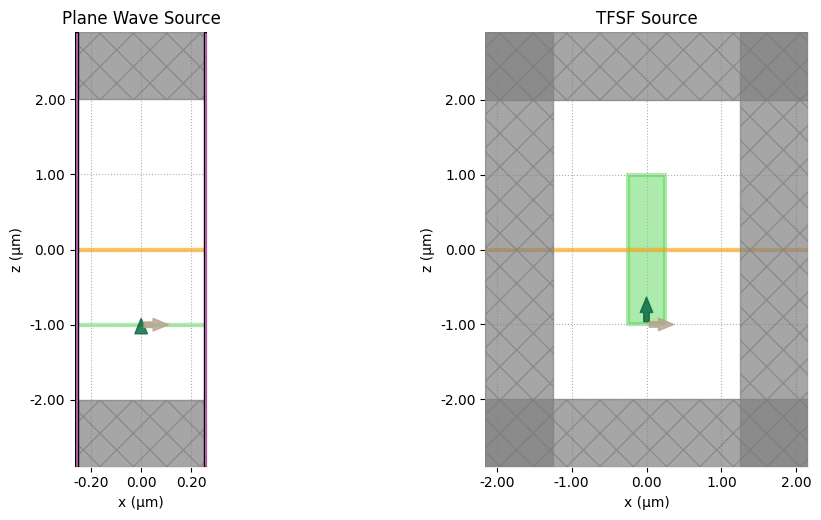

In [5]:
sim_pw = list(sims_PW.values())[0]
sim_tfsf = list(sims_TFSF.values())[0]

# create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"width_ratios": [3, 1]})

# plot fields at y = 0
sim_pw.plot(y=0, ax=ax1)
ax1.set_title("Plane Wave Source")
ax1.set_aspect(0.3)

sim_tfsf.plot(y=0, ax=ax2)
ax2.set_title("TFSF Source")

fig.tight_layout(pad=0)

plt.show()

In [6]:
# running the batch
batch_data_PW = batch_PW.run()
batch_data_TFSF = batch_TFSF.run()

Output()

14:02:25 -03 Started working on Batch containing 6 tasks.

14:02:31 -03 Maximum FlexCredit cost: 0.150 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

14:02:36 -03 Batch complete.

Output()

Output()

14:02:44 -03 Started working on Batch containing 6 tasks.

14:02:50 -03 Maximum FlexCredit cost: 1.369 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

14:02:55 -03 Batch complete.

Output()

Processing the results.

In [7]:
# plane wave field
Ex_PW = np.array(
    [batch_data_PW[str(s)]["field_mon"].Ex.sel(x=0, y=0, method="nearest").squeeze() for s in sizes]
)
Ey_PW = np.array(
    [batch_data_PW[str(s)]["field_mon"].Ey.sel(x=0, y=0, method="nearest").squeeze() for s in sizes]
)
Ez_PW = np.array(
    [batch_data_PW[str(s)]["field_mon"].Ez.sel(x=0, y=0, method="nearest").squeeze() for s in sizes]
)
E_PW = np.sqrt(np.abs(Ex_PW) ** 2 + np.abs(Ey_PW) ** 2 + np.abs(Ez_PW) ** 2)

# plane wave flux
flux_PW = [batch_data_PW[str(s)]["flux_mon"].flux.values.squeeze() for s in sizes]

# analytical |E| field for the plane wave
E0_PW = [np.sqrt(2 / (td.C_0 * 1 * td.EPSILON_0 * s**2)) for s in sizes]

# TFSF field
Ex_TFSF = np.array(
    [
        batch_data_TFSF[str(s)]["field_mon"].Ex.sel(x=0, y=0, method="nearest").squeeze()
        for s in sizes
    ]
)
Ey_TFSF = np.array(
    [
        batch_data_TFSF[str(s)]["field_mon"].Ey.sel(x=0, y=0, method="nearest").squeeze()
        for s in sizes
    ]
)
Ez_TFSF = np.array(
    [
        batch_data_TFSF[str(s)]["field_mon"].Ez.sel(x=0, y=0, method="nearest").squeeze()
        for s in sizes
    ]
)
E_TFSF = np.sqrt(np.abs(Ex_TFSF) ** 2 + np.abs(Ey_TFSF) ** 2 + np.abs(Ez_TFSF) ** 2)

# TFSF flux
flux_TFSF = [batch_data_TFSF[str(s)]["flux_mon"].flux.values.squeeze() for s in sizes]

# analytical |E| field for the TFSF source
E0_TFSF = [np.sqrt(2 / (td.C_0 * 1 * td.EPSILON_0)) for s in sizes]

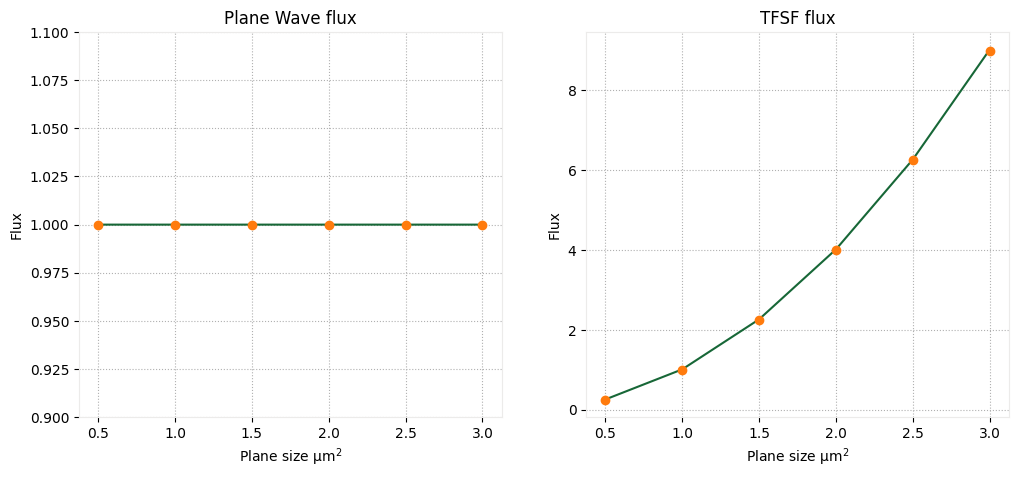

In [8]:
# visualizing the results
fig, Ax = plt.subplots(1, 2, figsize=(12, 5))

Ax[0].plot(sizes, flux_PW)
Ax[0].plot(sizes, [1 for i in sizes], "o")
Ax[0].set_ylim(0.9, 1.1)
Ax[0].set_title("Plane Wave flux")
Ax[0].set_xlabel("Plane size µm$^2$")
Ax[0].set_ylabel("Flux")

Ax[1].plot(sizes, flux_TFSF)
Ax[1].plot(sizes, [s**2 for s in sizes], "o")
Ax[1].set_title("TFSF flux")
Ax[1].set_xlabel("Plane size µm$^2$")
Ax[1].set_ylabel("Flux")


plt.show()

As shown in the figure above, the flux of the `PlaneWave` does not vary with the plane size, whereas it does for the `TFSF`.

Below, we illustrate the behavior of the electric field amplitude $|E_0|$, which exhibits the opposite trend.

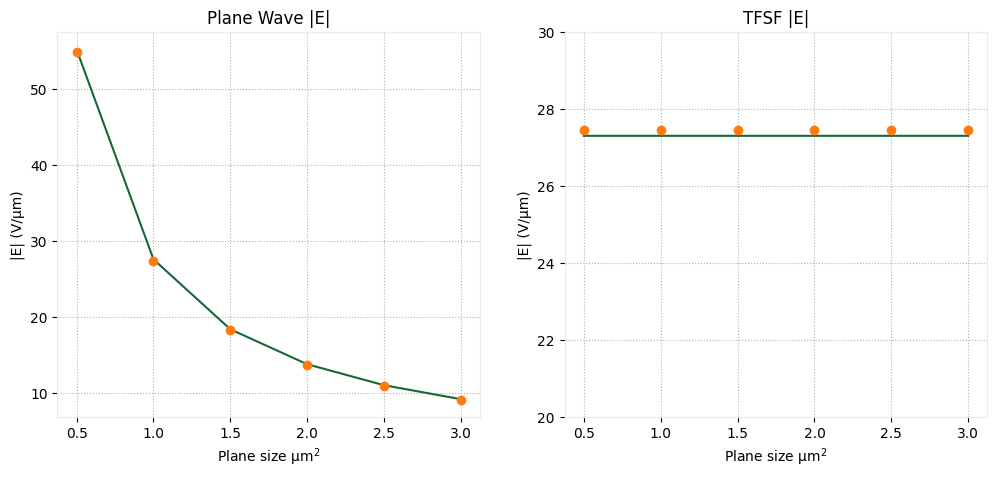

In [9]:
fig, Ax = plt.subplots(1, 2, figsize=(12, 5))

Ax[0].plot(sizes, E_PW)
Ax[0].plot(sizes, E0_PW, "o")

Ax[0].set_title("Plane Wave |E|")
Ax[0].set_xlabel("Plane size µm$^2$")
Ax[0].set_ylabel("|E| (V/µm)")

Ax[1].plot(sizes, E_TFSF)
Ax[1].plot(sizes, E0_TFSF, "o")
Ax[1].set_title("TFSF |E|")
Ax[1].set_xlabel("Plane size µm$^2$")
Ax[1].set_ylabel("|E| (V/µm)")
Ax[1].set_ylim(20, 30)

plt.show()

## Custom Field Source <a name="normalization"></a>

The [`CustomFieldSource`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.CustomFieldSource.html) object allows users to inject a planar field distribution directly into the simulation. More information on how to set up a `CustomFieldSource` can be found [here](https://docs.flexcompute.com/projects/tidy3d/en/latest/faq/docs/faq/how-do-i-set-a-custom-field-source.html).

For this type of source, **no automatic normalization** is applied, so the total power is determined by the source definition.

To illustrate this behavior, we will consider a simple x-polarized plane wave source. The fields are defined as:

$E_x = E_0e^{i(kz + \phi)}e^{-\omega t }$

$H_y = \frac{E_0}{\eta_0}e^{i(kz + \phi)}e^{-\omega t }$

As a result, the total power radiated by the source is determined by the value of $E_0$, as discussed in the previous section.


In [10]:
# x and y coordinates
x = np.linspace(-0.5, 0.5, 1001)
y = x
X, Y = np.meshgrid(x, y)

# central wavelength and E_0 definition
wl0 = td.C_0 / freq0
k = 2 * np.pi / wl0
E0 = 1

# field data definition
Ex_data = E0 * np.ones(X.shape) * np.exp(-1j * k)
Hy_data = (E0 / td.ETA_0) * np.ones(X.shape) * np.exp(-1j * k)

# FieldDataset definition
coords = {"x": x, "y": y, "z": [-1], "f": [freq0]}

Ex = td.ScalarFieldDataArray(Ex_data[..., None, None], coords=coords)
Hy = td.ScalarFieldDataArray(Hy_data[..., None, None], coords=coords)

dataset = td.FieldDataset(Ex=Ex, Hy=Hy)

# creating the CustomFieldSource
custom_src = td.CustomFieldSource(
    source_time=source_time,
    center=(0, 0, -1),
    size=(1, 1, 0),
    field_dataset=dataset,
)

In [11]:
# run the simulation with the custom source
sim = get_sim()

xz_mon = td.FieldMonitor(size=(td.inf, 0, td.inf), center=(0, 0, 0), name="xz_mon", freqs=[freq0])

sim_custom_source = sim.updated_copy(sources=[custom_src], monitors=list(sim.monitors) + [xz_mon])


sim_data_custom_source = web.run(sim_custom_source, "sim_custom_source")

14:03:18 -03 Created task 'sim_custom_source' with task_id                      
             'fdve-d4e00cdf-9d54-48df-8dc2-c3731a2f4944' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=139590;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4e00cdf-9d54-48df-8dc2-c3731a2f4944\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=895782;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4e00cdf-9d54-48df-8dc2-c3731a2f4944\taskId]8;;\]8;id=139590;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4e00cdf-9d54-48df-8dc2-c3731a2f4944\=]8;;\]8;id=779277;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4e00cdf-9d54-48df-8dc2-c3731a2f4944\fdve]8;;\]8;id=139590;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4e00cdf-9d54-48df-8dc2-c3731a2f4944\-d4e00cdf-9d5]8;;\
             ]8;id=139590;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4e00cdf-9d54-48df-8dc2-c3731a2f4944\4-48df-8dc2-c3731a2f4944']8;;\.

             Task folder: ]8;id=409329;https://tidy3d.simulation.cloud/folders/folder-a6dab55b-2b24-42c5-9131-af3f0dcf32a3\'default']8;;\.

Output()

14:03:21 -03 Maximum FlexCredit cost: 0.025. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

14:03:22 -03 status = success

Output()

14:03:25 -03 loading simulation from simulation_data.hdf5

In [12]:
flux = sim_data_custom_source["flux_mon"].flux
E = np.sqrt(
    np.abs(sim_data_custom_source["field_mon"].Ex) ** 2
    + np.abs(sim_data_custom_source["field_mon"].Ey) ** 2
    + np.abs(sim_data_custom_source["field_mon"].Ez) ** 2
)

As we can see, no additional normalization is applied, and the total flux closely matches the analytical expression for the given value of $E_0$.

In [13]:
# analytic flux
analytic_flux = (1 / 2) * td.C_0 * 1 * td.EPSILON_0 * abs(E0) ** 2
print(f"Flux:\t\t\t{flux[0]:.5f} [W]")
print(f"Flux analytic:\t\t{analytic_flux:.5f} [W]")
print(f"E0:\t\t\t{E.max():.5f} [V/µm]")

Flux:			0.00134 [W]
Flux analytic:		0.00133 [W]
E0:			1.00918 [V/µm]


## Monitor Placement <a name="normalization"></a>

When dealing with forward and backward waves, it is important to carefully consider the monitor type and its position, specially at moderate resolutions (around 10 steps per wavelength). When using a `DiffractionMonitor`, as demonstrated below, the error increases when the monitor needs to resolve forward and backward propagating fields with similar magnitudes.

Therefore, for highly reflective structures, the correct placement of the `DiffractionMonitor` is **behind** the source, where the forward-propagating field dominates. This helps minimize errors in the normalization process. 

Here, we illustrate this issue using a plane wave incident on a dielectric interface at oblique incidence, varying the angle of incidence until the condition for total internal reflection (TIR) is reached.

In [14]:
# medium for the dielectric interface
medium = td.Medium(permittivity=3.5**2)

# defining FluxMonitors and DiffractionMonitors for computing the flux
structure = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-100, -100, -100), rmax=(100, 100, 0)), medium=medium
)
# flux monitor behind the source
flux_mon_back = td.FluxMonitor(
    name="flux_mon_back",
    size=(td.inf, td.inf, 0),
    center=(0, 0, -1.5),
    freqs=[freq0],
)
# flux monitor in front of the source
flux_mon_front = td.FluxMonitor(
    name="flux_mon_front",
    size=(td.inf, td.inf, 0),
    center=(0, 0, -0.5),
    freqs=[freq0],
)

# diffraction monitor behind the source
diff_mon_back = td.DiffractionMonitor(
    name="diff_mon_back",
    size=(td.inf, td.inf, 0),
    center=(0, 0, -1.5),
    freqs=[freq0],
    normal_dir="-",
)
# diffraction monitor in front of the source
diff_mon_front = td.DiffractionMonitor(
    name="diff_mon_front",
    size=(td.inf, td.inf, 0),
    center=(0, 0, -0.5),
    freqs=[freq0],
    normal_dir="-",
)

# normalization monitor in front of the source
norm_monitor = td.DiffractionMonitor(
    name="norm_monitor",
    size=(td.inf, td.inf, 0),
    center=(0, 0, -0.5),
    freqs=[freq0],
)

monitors = [flux_mon_back, flux_mon_front, diff_mon_back, diff_mon_front, norm_monitor]

In [15]:
# create simulations for different angles until total internal reflection
thetas2 = [0, 5, 10, 15, 20, 25]

sims_PW_ref = {}

for t in thetas2:
    sim = get_sim(
        source_type="PW",
        theta_degree=t,
        bloch_medium=medium,
        pol_angle_degree=90,
        structures=[structure],
        min_steps_per_wvl=10,
    )
    sims_PW_ref[t] = sim.updated_copy(monitors=monitors)

batch_PW_ref = web.Batch(simulations=sims_PW_ref, folder_name="plane_wave_ref")

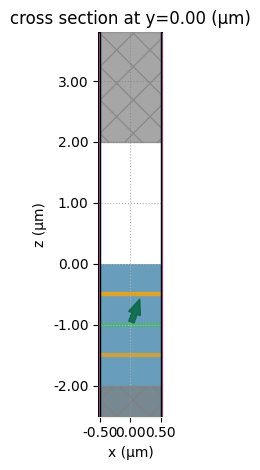

In [16]:
# visualizing the simulation setup
sims_PW_ref[20].plot(y=0)

plt.show()

In [17]:
# running the batch
batch_data_PW_ref = batch_PW_ref.run()

Output()

14:03:28 -03 Started working on Batch containing 6 tasks.

14:03:34 -03 Maximum FlexCredit cost: 0.150 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

14:03:39 -03 Batch complete.

Output()

In [18]:
# function for calculating the analytical Fresnel reflection coefficient for s-polarized light
def fresnel_rs(n1, n2, theta_i_deg):
    theta_i = np.radians(theta_i_deg)
    theta_t = np.arcsin(n1 * np.sin(theta_i) / n2 + 0j)
    r_s = (n1 * np.cos(theta_i) - n2 * np.cos(theta_t)) / (
        n1 * np.cos(theta_i) + n2 * np.cos(theta_t)
    )

    return abs(r_s) ** 2

In [19]:
# computing the reflection
reflection_analytic = fresnel_rs(3.5, 1, thetas2)

flux_front = np.array([batch_data_PW_ref[str(t)]["flux_mon_front"].flux for t in thetas2]).flatten()
flux_back = np.array([batch_data_PW_ref[str(t)]["flux_mon_back"].flux for t in thetas2]).flatten()

diff_front = np.array(
    [batch_data_PW_ref[str(t)]["diff_mon_front"].power.sum() for t in thetas2]
).flatten()
diff_back = np.array(
    [batch_data_PW_ref[str(t)]["diff_mon_back"].power.sum() for t in thetas2]
).flatten()

norm = np.array([batch_data_PW_ref[str(t)]["norm_monitor"].power.sum() for t in thetas2]).flatten()

As we can see, when TIR occurs, the error for the `DiffractionMonitor` placed in front of the source increases.

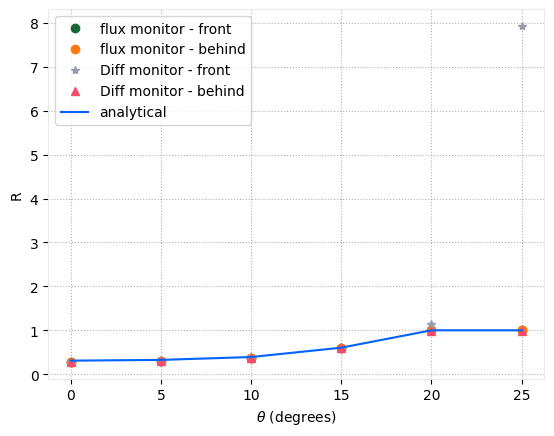

In [20]:
# visualizing the results
fig, ax = plt.subplots()
ax.plot(thetas2, 1 - flux_front, "o", label="flux monitor - front")
ax.plot(thetas2, -flux_back, "o", label="flux monitor - behind")

ax.plot(thetas2, diff_front, "*", label="Diff monitor - front")

ax.plot(thetas2, diff_back, "^", label="Diff monitor - behind")

ax.plot(thetas2, reflection_analytic, label="analytical")

ax.legend()

ax.set_ylabel("R")
ax.set_xlabel("$\\theta$ (degrees)")

plt.show()

We can also visualize the relative error across the different monitors.

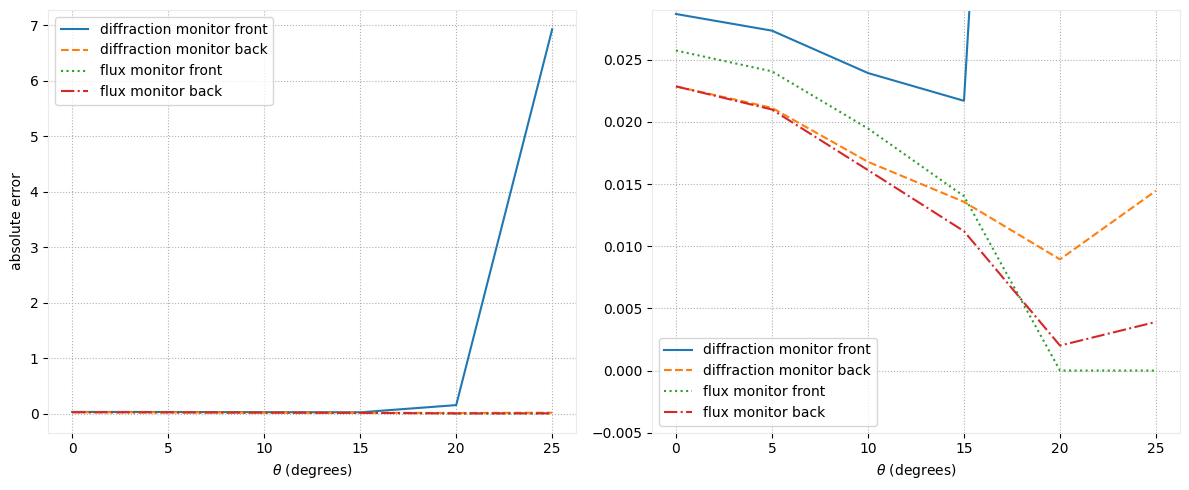

In [21]:
import matplotlib.pyplot as plt

# define consistent colors
colors = {
    "diff_front": "tab:blue",
    "diff_back": "tab:orange",
    "flux_front": "tab:green",
    "flux_back": "tab:red",
}


def plot_errors(ax):
    ax.plot(
        thetas2,
        abs(reflection_analytic - diff_front),
        "-",
        label="diffraction monitor front",
        color=colors["diff_front"],
    )
    ax.plot(
        thetas2,
        abs(reflection_analytic - diff_back),
        "--",
        label="diffraction monitor back",
        color=colors["diff_back"],
    )
    ax.plot(
        thetas2,
        abs(reflection_analytic - (1 - flux_front)),
        ":",
        label="flux monitor front",
        color=colors["flux_front"],
    )
    ax.plot(
        thetas2,
        abs(reflection_analytic - (-flux_back)),
        "-.",
        label="flux monitor back",
        color=colors["flux_back"],
    )
    ax.set_xlabel("$\\theta$ (degrees)")
    ax.legend()


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_errors(axes[0])
axes[0].set_ylabel("absolute error")
axes[1].set_ylim(-0.005, 0.029)

plot_errors(axes[1])

plt.tight_layout()
plt.show()

As shown, the `DiffractionMonitor` exhibits high error when used for normalization in the presence of forward- and backward-propagating fields of equal magnitude. In contrast, the `FluxMonitor` maintains an error below 1% under the same conditions.

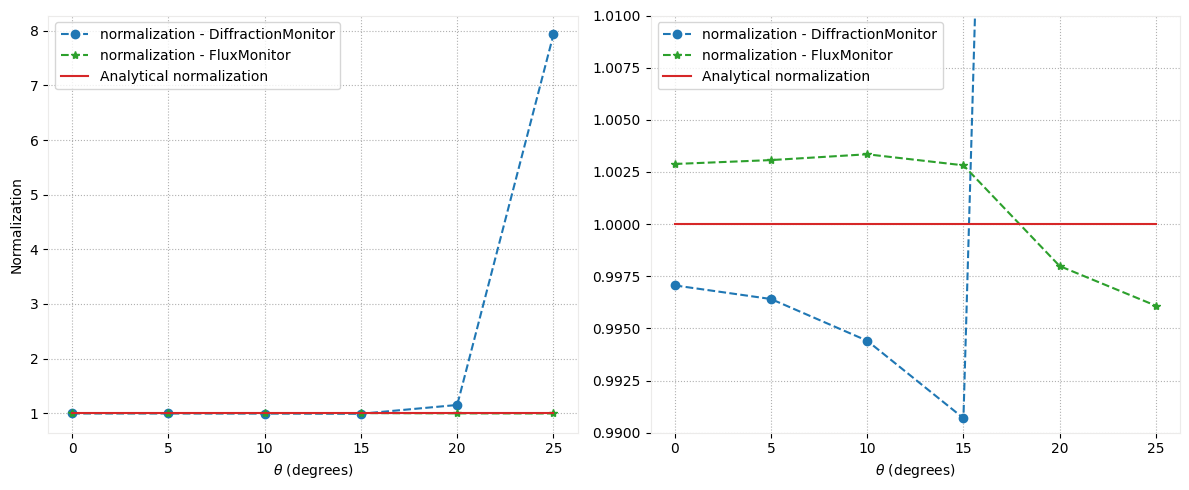

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
ax1.plot(
    thetas2, norm, "--o", label="normalization - DiffractionMonitor", color=colors["diff_front"]
)
ax1.plot(
    thetas2,
    flux_front - flux_back,
    "--*",
    label="normalization - FluxMonitor",
    color=colors["flux_front"],
)
ax1.plot(thetas2, [1 for _ in thetas2], label="Analytical normalization", color=colors["flux_back"])
ax1.set_xlabel("$\\theta$ (degrees)")
ax1.set_ylabel("Normalization")
ax1.legend()

ax2 = axes[1]
ax2.plot(
    thetas2, norm, "--o", label="normalization - DiffractionMonitor", color=colors["diff_front"]
)
ax2.plot(
    thetas2,
    flux_front - flux_back,
    "--*",
    label="normalization - FluxMonitor",
    color=colors["flux_front"],
)
ax2.plot(thetas2, [1 for _ in thetas2], label="Analytical normalization", color=colors["flux_back"])
ax2.set_xlabel("$\\theta$ (degrees)")
ax2.set_ylim(0.99, 1.01)
ax2.legend()

plt.tight_layout()
plt.show()

### Increasing resolution

Now, we investigate the relative error for the `DiffractionMonitor` and `FluxMonitor` as a function of the resolution.

In [23]:
# create simulations for different angles until total internal reflection
resolutions_pw = [10, 20, 30, 40]
sims_PW_res = {}

for r in resolutions_pw:
    sim = get_sim(
        source_type="PW",
        theta_degree=20,
        bloch_medium=medium,
        pol_angle_degree=90,
        structures=[structure],
        min_steps_per_wvl=r,
    )
    sims_PW_res[r] = sim.updated_copy(monitors=monitors)

batch_PW_res = web.Batch(simulations=sims_PW_res, folder_name="plane_wave_ref")

In [24]:
batch_data_PW_res = batch_PW_res.run()

Output()

14:03:57 -03 Started working on Batch containing 4 tasks.

14:04:02 -03 Maximum FlexCredit cost: 0.892 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

14:04:05 -03 Batch complete.

Output()

In [25]:
# computing the reflection
flux_front_res = np.array(
    [batch_data_PW_res[str(r)]["flux_mon_front"].flux for r in resolutions_pw]
).flatten()
diff_front_res = np.array(
    [batch_data_PW_res[str(r)]["diff_mon_front"].power.sum() for r in resolutions_pw]
).flatten()

flux_back_res = np.array(
    [batch_data_PW_res[str(r)]["flux_mon_back"].flux for r in resolutions_pw]
).flatten()
diff_back_res = np.array(
    [batch_data_PW_res[str(r)]["diff_mon_back"].power.sum() for r in resolutions_pw]
).flatten()

error_flux_front = [abs(i - reflection_analytic[-1]) for i in (1 - flux_front_res)]
error_diff_front = [abs(i - reflection_analytic[-1]) for i in diff_front_res]

error_flux_back = [abs(i - reflection_analytic[-1]) for i in (-flux_back_res)]
error_diff_back = [abs(i - reflection_analytic[-1]) for i in diff_back_res]

The error for the `DiffractionMonitor` placed in front of the source rapidly decreases as the resolution increases, but it remains slightly higher than that of the `FluxMonitor`. In contrast, the `DiffractionMonitor` placed behind the source shows less than 1% error even at modest resolutions, becoming very similar to the `FluxMonitor` at slightly higher resolutions.

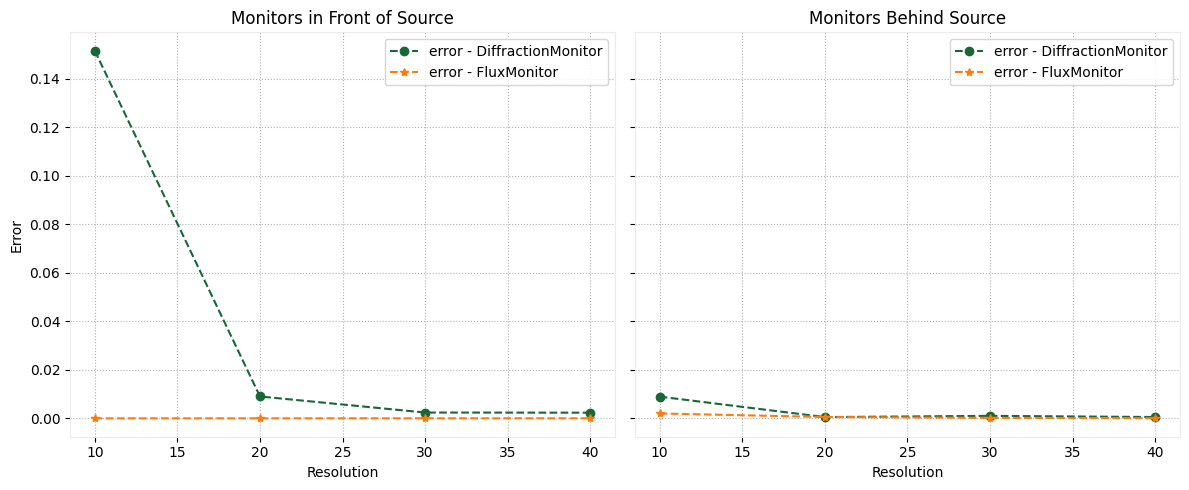

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# plot errors for monitors in front of the source
ax1.plot(resolutions_pw, error_diff_front, "--o", label="error - DiffractionMonitor")
ax1.plot(resolutions_pw, error_flux_front, "--*", label="error - FluxMonitor")
ax1.set_title("Monitors in Front of Source")
ax1.set_xlabel("Resolution")
ax1.set_ylabel("Error")
ax1.legend()

# plot errors for monitors behind the source
ax2.plot(resolutions_pw, error_diff_back, "--o", label="error - DiffractionMonitor")
ax2.plot(resolutions_pw, error_flux_back, "--*", label="error - FluxMonitor")
ax2.set_title("Monitors Behind Source")
ax2.set_xlabel("Resolution")
ax2.legend()

plt.tight_layout()
plt.show()

In conclusion, the `DiffractionMonitor` is effective for calculating diffraction orders and flux when positioned appropriately. However, caution is needed in setups with high reflectance, where its location becomes critical.


## Dipole Source <a name="dipole"></a>

The [PointDipole](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PointDipole.html) follows a different normalization scheme compared to other sources. Its spectral power is governed by the analytical expression for a infinitesimal antenna with a fixed current density, which is **not constant with respect to frequency.**

The frequency dependence of the radiated power for a 3D electric current dipole follows:

$$P(\nu) = \frac{\mu_0 n}{12\pi c} \omega^2$$
where:
- $\mu_0$ is the permeability of free space,
- $n$ is the refractive index of the medium,
- $c$ is the speed of light,
- $\omega$ is the angular frequency.

For a magnetic current dipole or lower-dimensional sources (2D and 1D), the equation differs slightly. You can find more details in our [documentation](https://docs.flexcompute.com/projects/tidy3d/en/latest/faq/docs/faq/How-are-results-normalized.html).


Unlike sources like plane waves or total-field scattered-field (TFSF) sources, which are typically normalized through their power or amplitude across frequency, the dipole source spectrum reflects the physical reality of how an oscillating dipole behaves.

To illustrate, we will create a model with a `PointDipole` with $E_z$ polarization, placed at the center of the simulation domain, surrounded by `FluxMonitor` to compute the irradiated flux.


In [27]:
# dipole source
dipole = td.PointDipole(center=(0, 0, 0), source_time=source_time, polarization="Ez")

freqs = np.linspace(freq0 - fwidth, freq0 + fwidth, 101)

# flux monitor around the dipole source
flux_mon = td.FluxMonitor(
    name="flux_mon",
    size=(1, 1, 1),
    center=(0, 0, 0),
    freqs=freqs,
)
sim_pd = get_sim(size=3, source_type="TFSF")
sim_pd = sim_pd.updated_copy(size=(3, 3, 3), sources=[dipole], monitors=[flux_mon])
sim_data_pd = web.run(sim_pd, "point_dipole")

14:04:16 -03 Created task 'point_dipole' with task_id                           
             'fdve-7a54b4d5-4e6c-4ee4-a40a-60e5604cbe37' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=768874;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7a54b4d5-4e6c-4ee4-a40a-60e5604cbe37\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=163117;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7a54b4d5-4e6c-4ee4-a40a-60e5604cbe37\taskId]8;;\]8;id=768874;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7a54b4d5-4e6c-4ee4-a40a-60e5604cbe37\=]8;;\]8;id=540688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7a54b4d5-4e6c-4ee4-a40a-60e5604cbe37\fdve]8;;\]8;id=768874;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7a54b4d5-4e6c-4ee4-a40a-60e5604cbe37\-7a54b4d5-4e6]8;;\
             ]8;id=768874;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7a54b4d5-4e6c-4ee4-a40a-60e5604cbe37\c-4ee4-a40a-60e5604cbe37']8;;\.

             Task folder: ]8;id=680807;https://tidy3d.simulation.cloud/folders/folder-a6dab55b-2b24-42c5-9131-af3f0dcf32a3\'default']8;;\.

Output()

14:04:18 -03 Maximum FlexCredit cost: 0.283. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

14:04:19 -03 status = success

Output()

14:04:21 -03 loading simulation from simulation_data.hdf5

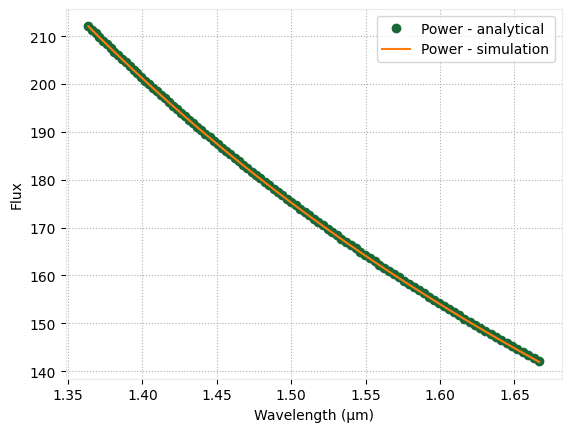

In [28]:
# visualizing the results
flux = [(td.MU_0 / (12 * np.pi * td.C_0)) * (2 * np.pi * f) ** 2 for f in freqs]
wvls = td.C_0 / freqs

fig, ax = plt.subplots()
ax.plot(wvls, flux, "o", label="Power - analytical")
ax.plot(wvls, sim_data_pd["flux_mon"].flux, label="Power - simulation")
ax.legend()
ax.set_xlabel("Wavelength (µm)")
ax.set_ylabel("Flux")

plt.show()

## Current Source <a name="currentSource"></a> 

For a finite-size current source, the analytical expression becomes more complex, hence a normalization run might be necessary in some cases. 

However, an approximation for small-area current dipoles can be derived, as described in Chapter 4.5 of the book `Balanis, C. A. (2005). Antenna Theory: Analysis and Design (3rd ed.). Wiley‑Interscience`:

$$
P = \eta \frac{I^2}{8\pi^2} \int\!\!\int \frac{\left[\cos\left(\frac{kl}{2} \cos\theta\right) - \cos\left(\frac{kl}{2}\right)\right]^2}{\sin(\theta)} \, d\theta \, d\phi
$$

To compare the emitted flux with the analytical expression, we need to compute the total current using Faraday's Law of Induction.

To illustrate this, we sweep across a range of source areas and compute both the analytical and simulated power.

In [29]:
# function for calculating the current
def faraday_law(monitor):
    Hx = monitor.Hx
    Hy = monitor.Hy

    # integrate over a closed circuit
    current = -(
        -Hx.sel(y=Hx.y.max()).squeeze().integrate("x")
        + -Hy.sel(x=Hy.x.min()).squeeze().integrate("y")
        + Hx.sel(y=Hx.y.min()).squeeze().integrate("x")
        + Hy.sel(x=Hy.x.max()).squeeze().integrate("y")
    )

    return current

In [30]:
# create and run the simulation batch
sims_cs = {}
source_sizes = [
    0.2,
    0.4,
    0.6,
    0.8,
    1,
]
for i in source_sizes:
    current_source = td.UniformCurrentSource(
        center=(0, 0, 0), source_time=source_time, polarization="Ez", size=(i, i, 1)
    )

    # flux monitor around the dipole source
    flux_mon = td.FluxMonitor(
        name="flux_mon",
        size=(2, 2, 2),
        center=(0, 0, 0),
        freqs=[freq0],
    )

    # field monitor for calculating the current
    current_monitor = td.FieldMonitor(
        name="current_monitor", size=(3, 3, 0), center=(0, 0, 0), freqs=[freq0]
    )

    sim_cs = get_sim(size=3, source_type="TFSF")
    sim_cs = sim_cs.updated_copy(
        size=(4.5, 4.5, 4.5), sources=[current_source], monitors=[flux_mon, current_monitor]
    )
    sims_cs[i] = sim_cs

Visualizing the model.

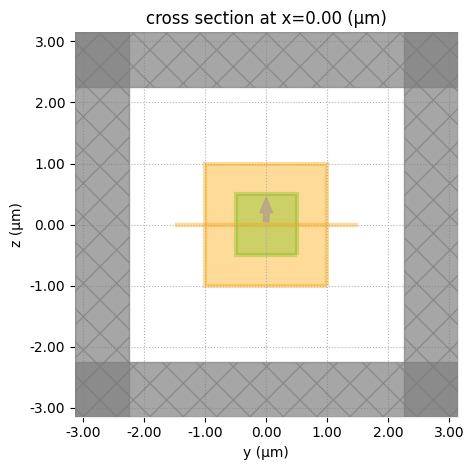

In [31]:
sim_cs.plot(x=0)

plt.show()

In [32]:
batch_cs = web.Batch(simulations=sims_cs, folder_name="UniformCurrentSource")
batch_cs_data = batch_cs.run()

Output()

14:04:24 -03 Started working on Batch containing 5 tasks.

14:04:29 -03 Maximum FlexCredit cost: 2.122 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

14:04:33 -03 Batch complete.

Output()

In [33]:
currents = []
fluxes = []


for i in source_sizes:
    sim_data = batch_cs_data[str(i)]
    fluxes.append(sim_data["flux_mon"].flux)
    currents.append(faraday_law(sim_data["current_monitor"]))

# calculate the analytical power

from scipy.integrate import quad

wl0 = td.C_0 / freq0
kl = 2 * np.pi * wl0 * 1
func = lambda theta: (np.cos((kl / 2) * np.cos(theta)) + np.cos(kl / 2)) ** 2 / np.sin(theta)
integral = 2 * np.pi * quad(func, 0, np.pi)[0]

analytic_power = [((td.ETA_0 * np.abs(I) ** 2) / (8 * np.pi**2)) * integral for I in currents]

As we can see, the computed flux follows the analytical expression for small-area sources, but the error increases for larger areas where the approximation no longer holds.

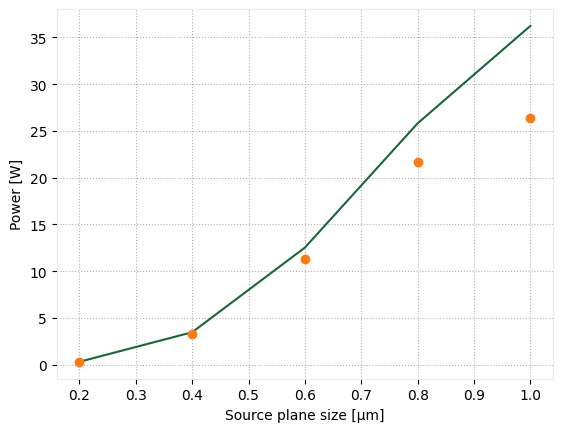

In [34]:
fig, ax = plt.subplots()

ax.plot(source_sizes, fluxes)
ax.plot(source_sizes, analytic_power, "o")

ax.set_xlabel("Source plane size [µm]")
ax.set_ylabel("Power [W]")

plt.show()

### One-Dimensional Current Source

For 2D and 1D sources, a normalization is applied to ensure that the emitted power remains independent of the simulation resolution. 

This can be illustrated by simulating a line source at different resolutions and comparing the emitted power in each case.

In [35]:
resolutions = [10, 20, 30, 40, 50]
sims_cs_0 = {}

for i in resolutions:
    current_source = td.UniformCurrentSource(
        center=(0, 0, 0), source_time=source_time, polarization="Ez", size=(0, 0, 1)
    )

    sim_cs_0 = get_sim(size=3, source_type="TFSF", min_steps_per_wvl=i)
    sim_cs_0 = sim_cs_0.updated_copy(
        size=(4.5, 4.5, 4.5), sources=[current_source], monitors=[flux_mon, current_monitor]
    )
    sims_cs_0[i] = sim_cs_0

batch_cs_0 = web.Batch(simulations=sims_cs_0, folder_name="UniformCurrentSource_0")
batch_cs_data_0 = batch_cs_0.run()

Output()

14:04:44 -03 Started working on Batch containing 5 tasks.

14:04:50 -03 Maximum FlexCredit cost: 2.569 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

14:04:54 -03 Batch complete.

Output()

In [36]:
currents_0 = []
fluxes_0 = []

for i in resolutions:
    sim_data = batch_cs_data_0[str(i)]
    fluxes_0.append(sim_data["flux_mon"].flux)
    currents_0.append(faraday_law(sim_data["current_monitor"]))

As we can see, the results are close to the approximated analytical expression.

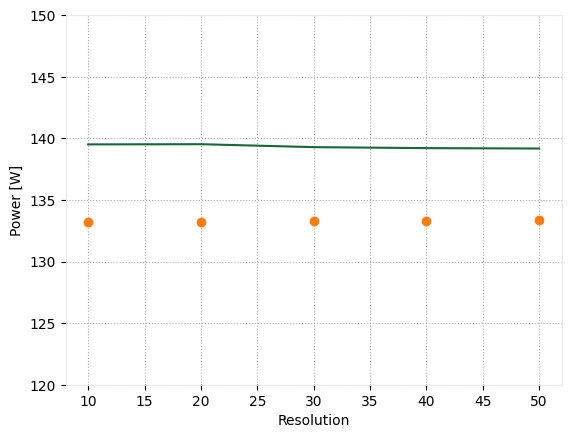

In [37]:
fig, ax = plt.subplots()

analytic_power_0 = [((td.ETA_0 * np.abs(I) ** 2) / (8 * np.pi**2)) * integral for I in currents_0]

ax.plot(resolutions, fluxes_0)
ax.plot(resolutions, analytic_power_0, "o")

ax.set_xlabel("Resolution")
ax.set_ylabel("Power [W]")

ax.set_ylim(120, 150)

plt.show()

In conclusion, although an approximate expression can be derived for the power emitted by a `UniformCurrentSource`, most practical cases do not satisfy the approximation assumptions. Therefore, if accurate normalization is required, a normalization run should be performed to directly compute the emitted power under the simulation setup.
